In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# 1. FFT grid on a fixed interval [x_min, x_max]
#    x_min = min(data) - margin, x_max = max(data) + margin
# ============================================================

stocks = np.load('data/plr_stocks.npy')

def setup_fft_grid(data, N=16384, margin=10.0):
    """
    Build an x-grid and corresponding frequency grid for FFT-based
    density inversion.

    Parameters
    ----------
    data : array_like
        1D array of returns (used to choose the range).
    N : int
        Number of grid points (power of 2 recommended).
    margin : float
        Extra padding added on both sides:
        x_min = min(data) - margin
        x_max = max(data) + margin

    Returns
    -------
    grid : dict
        Contains x_grid, t_grid, etc., used by pdf_grid_from_params.
    """
    data = np.asarray(data)
    data_min = float(data.min())
    data_max = float(data.max())

    x_min = data_min - margin
    x_max = data_max + margin

    L = x_max - x_min      # total length
    dx = L / N
    x_grid = x_min + dx * np.arange(N)

    # Frequency grid for the Fourier inversion (centered around 0)
    k = np.arange(N)
    t_grid = 2.0 * np.pi * (k - N/2) / L

    # (-1)^k factor used in the inversion formula
    alt_sign = (-1.0) ** k

    grid = {
        "x_grid": x_grid,
        "x_min": x_min,
        "x_max": x_max,
        "dx": dx,
        "L": L,
        "N": N,
        "t_grid": t_grid,
        "alt_sign": alt_sign,
    }
    return grid


# ============================================================
# 2. Characteristic function of weighted sum of chi^2_1 + location
#    X = mu + sum_{k=1}^K w_k * Z_k,  Z_k ~ chi^2_1 iid
# ============================================================

def cf_weighted_chi2_1(t, w, mu):
    """
    Characteristic function of:
        X = mu + sum_{k=1}^K w_k * Z_k,   Z_k ~ chi^2_1, iid.

    Parameters
    ----------
    t : array_like, shape (N,)
        Frequency grid.
    w : array_like, shape (K,)
        Weights (unconstrained).
    mu : float
        Location parameter.

    Returns
    -------
    cf : ndarray, shape (N,), complex
        CF evaluated at all t.
    """
    t = np.asarray(t)
    w = np.atleast_1d(w)

    # t: (N,1), w: (1,K) => T: (N,K)
    T = t[:, None] * w[None, :]

    # CF of chi^2_1 at scaled argument: (1 - 2 i w_k t)^(-1/2)
    cf_components = (1.0 - 2.0j * T) ** (-0.5)   # shape (N,K)

    # Product over components -> shape (N,)
    cf_prod = cf_components.prod(axis=1)

    # Multiply by location shift: e^{i mu t}
    cf = np.exp(1.0j * mu * t) * cf_prod

    return cf


# ============================================================
# 3. PDF on the FFT grid for a given parameter vector
# ============================================================

def pdf_grid_from_params(theta, grid, K):
    """
    Compute the approximate pdf on grid['x_grid'] for parameters theta.

    Parameters
    ----------
    theta : array_like, shape (K+1,)
        Parameter vector [mu, w_1, ..., w_K].
    grid : dict
        Output of setup_fft_grid.
    K : int
        Number of chi^2 components.

    Returns
    -------
    pdf_grid : ndarray, shape (N,)
        Approximate pdf of X on grid['x_grid'].
    """
    mu = theta[0]
    w = theta[1:1 + K]

    t = grid["t_grid"]
    a = grid["x_min"]
    L = grid["L"]
    alt = grid["alt_sign"]

    # CF on t-grid
    cf = cf_weighted_chi2_1(t, w, mu)

    # Shift by a: phi(t) * e^{-i t a}
    cf_tilde = cf * np.exp(-1.0j * t * a)

    # FFT-based inversion:
    # f_j ≈ (1/L) * (-1)^j * FFT( cf_tilde )[j]
    F = np.fft.fft(cf_tilde)
    pdf_grid = np.real(F * alt) / L

    # Clamp tiny negative values from numerical noise
    pdf_grid = np.maximum(pdf_grid, 0.0)

    return pdf_grid


# ============================================================
# 4. Negative log-likelihood using FFT-based pdf
# ============================================================

def neg_loglik(theta, data, grid, K):
    """
    Negative log-likelihood for the weighted chi^2_1 sum model,
    using FFT-based approximate pdf.

    Parameters
    ----------
    theta : array_like, shape (K+1,)
        [mu, w_1, ..., w_K]
    data : array_like, shape (n,)
        Observed returns.
    grid : dict
        Precomputed FFT grid (setup_fft_grid).
    K : int
        Number of components.

    Returns
    -------
    nll : float
        Negative log-likelihood.
    """
    data = np.asarray(data)

    pdf_grid = pdf_grid_from_params(theta, grid, K)
    x_grid = grid["x_grid"]

    # Interpolate pdf at data points
    f_vals = np.interp(data, x_grid, pdf_grid, left=0.0, right=0.0)

    # Avoid log(0)
    eps = 1e-300
    f_vals = np.maximum(f_vals, eps)

    nll = -np.sum(np.log(f_vals))
    return nll


# ============================================================
# 5. Parameter initialization (your requested scheme)
# ============================================================

def initial_theta(K):
    """
    Your custom initializations:
        if K == 2: [0, -1, 1]
        if K == 3: [0, -1, 1, -2]
        if K == 4: [0, -1, 1, -2, 2]
        if K == 5: [0, -1, 1, -2, 2, -3]
    """
    if K == 2:
        return np.array([0.0, -1.0, 1.0])
    if K == 3:
        return np.array([0.0, -1.0, 1.0, -2.0])
    if K == 4:
        return np.array([0.0, -1.0, 1.0, -2.0, 2.0])
    if K == 5:
        return np.array([0.0, -1.0, 1.0, -2.0, 2.0, -3.0])
    raise ValueError("K must be 2, 3, 4, or 5.")


# Experiment for $K\in[2,3,4,5]$


=== Fitting model with K = 2 components ===
  Initial theta0: [ 0. -1.  1.]
  success: True
  theta_hat: [ 6.78780632e-04 -1.45581425e+00  1.50917895e+00]
  log-likelihood: -18733.598092
  AIC: 37473.196183
  BIC: 37494.157774


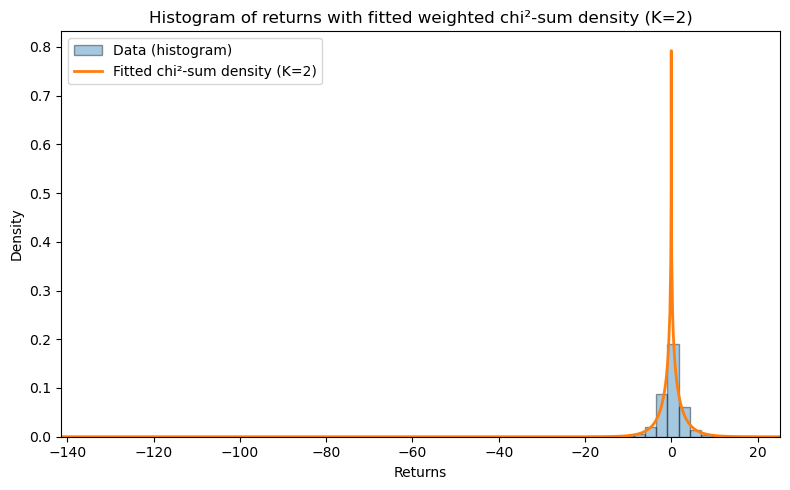


=== Fitting model with K = 3 components ===
  Initial theta0: [ 0. -1.  1. -2.]
  success: True
  theta_hat: [ 0.76083341 -1.01443881  1.32767872 -1.01813058]
  log-likelihood: -18620.390535
  AIC: 37248.781070
  BIC: 37276.729857


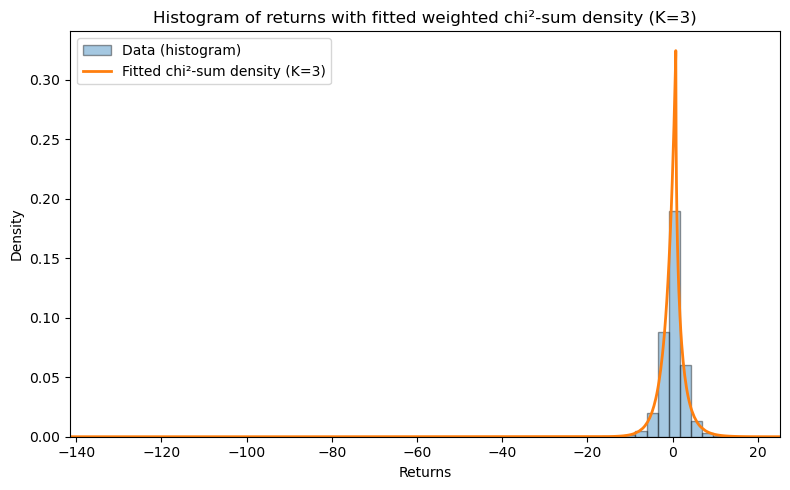


=== Fitting model with K = 4 components ===
  Initial theta0: [ 0. -1.  1. -2.  2.]
  success: True
  theta_hat: [ 0.00392863 -0.63441642  0.88962625 -1.180034    0.97135776]
  log-likelihood: -18515.226655
  AIC: 37040.453311
  BIC: 37075.389295


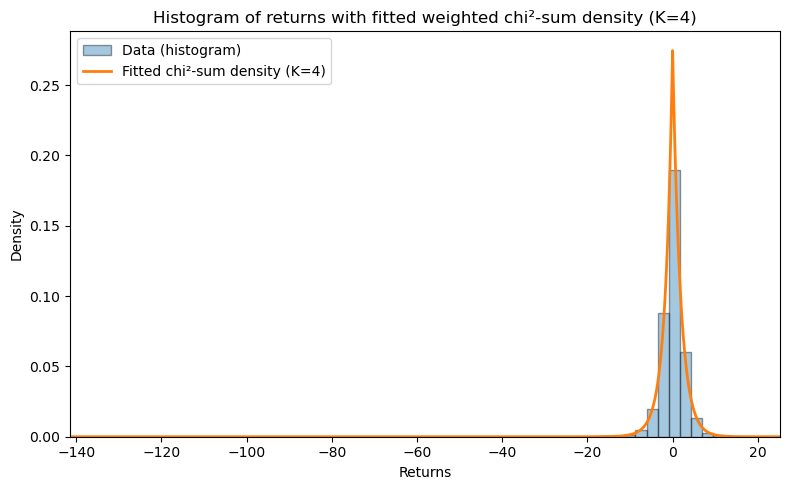


=== Fitting model with K = 5 components ===
  Initial theta0: [ 0. -1.  1. -2.  2. -3.]
  success: True
  theta_hat: [ 0.87799443 -0.65129324  0.36175646 -0.65907723  1.193865   -1.06937288]
  log-likelihood: -18545.618902
  AIC: 37103.237805
  BIC: 37145.160986


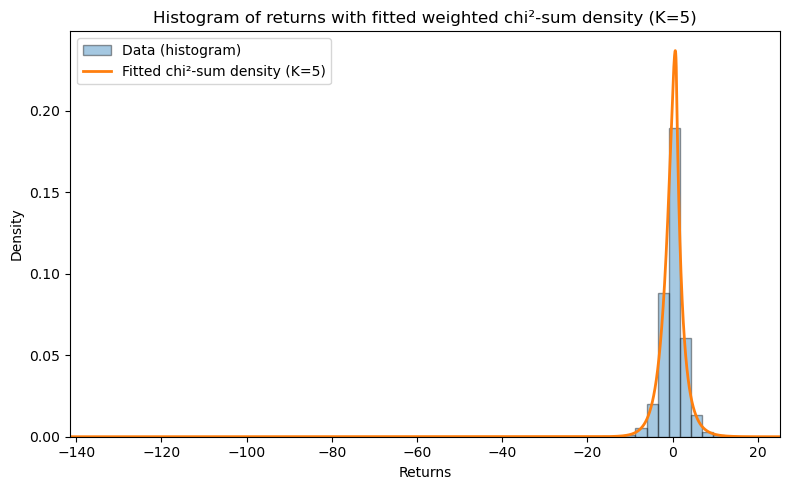


Done. 'results[K]' holds the optimization result for each K.


In [29]:
# ============================================================
# Assumption: 'data' is a 1D numpy array of returns
# ============================================================

# Build a fine FFT grid, with symmetric margin around [min(data), max(data)]
N_fft = 16384       # fine grid (can increase if needed)
margin = 10.0       # you can tune this depending on the scale of returns

grid = setup_fft_grid(data, N=N_fft, margin=margin)

K_list = [2, 3, 4, 5]
results = {}

n = len(data)

for K in K_list:
    print(f"\n=== Fitting model with K = {K} components ===")

    theta0 = initial_theta(K)
    print("  Initial theta0:", theta0)

    res = minimize(
        fun=neg_loglik,
        x0=theta0,
        args=(data, grid, K),
        method="L-BFGS-B",
        tol=1e-6,
    )

    results[K] = res

    print("  success:", res.success)
    print("  theta_hat:", res.x)

    # Log-likelihood, AIC, BIC
    loglik = -res.fun
    p = len(res.x)              # number of parameters
    AIC = 2 * p - 2 * loglik
    BIC = p * np.log(n) - 2 * loglik

    print(f"  log-likelihood: {loglik:.6f}")
    print(f"  AIC: {AIC:.6f}")
    print(f"  BIC: {BIC:.6f}")

    # ---- Plot histogram + FFT-based fitted density ----
    theta_hat = res.x
    pdf_grid = pdf_grid_from_params(theta_hat, grid, K)
    x_grid = grid["x_grid"]

    # Plot range
    x_min_plot = grid["x_min"]        # you can also hard-code -40 if you prefer
    x_max_plot = float(np.max(data))  # upper bound at max(data)

    # Restrict pdf to this range for plotting
    mask = (x_grid >= x_min_plot) & (x_grid <= x_max_plot)
    x_plot = x_grid[mask]
    pdf_plot = pdf_grid[mask]

    plt.figure(figsize=(8, 5))

    # Histogram using ALL data for proper density normalization
    plt.hist(
        data,
        bins=60,
        density=True,
        alpha=0.4,
        edgecolor='k',
        label='Data (histogram)'
    )

    # Overlay fitted density from FFT
    plt.plot(
        x_plot,
        pdf_plot,
        linewidth=2,
        label=f'Fitted chi²-sum density (K={K})'
    )

    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title(f'Histogram of returns with fitted weighted chi²-sum density (K={K})')
    plt.xlim(x_min_plot, x_max_plot)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nDone. 'results[K]' holds the optimization result for each K.")


# Computations for all 25 stocks

In [32]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# ------------------------------------------------------------
# Assumption: 'stocks' is a list (or iterable) of 1D np.arrays,
#             each corresponding to one stock's return series.
# ------------------------------------------------------------

K_list = [2, 3, 4, 5]
N_fft = 16384 * 2   # very fine grid
margin = 10.0       # symmetric margin around [min(stock), max(stock)]

# Will hold: results_per_K[ K ] = list of dicts (one dict per stock)
results_per_K = {K: [] for K in K_list}

for K in K_list:
    print(f"\n=== Fitting model for K = {K} ===")
    
    for stock_idx, stock in enumerate(stocks, start=1):
        data = np.asarray(stock)
        n = len(data)
        
        # Build FFT grid for this stock
        grid = setup_fft_grid(data, N=N_fft, margin=margin)
        
        # Initial parameters
        theta0 = initial_theta(K)
        
        # Optimize
        res = minimize(
            fun=neg_loglik,
            x0=theta0,
            args=(data, grid, K),
            method="L-BFGS-B",
            tol=1e-6,
        )
        
        if not res.success:
            print(f"  Warning: optimization did not fully converge for stock {stock_idx}, K={K}")
        
        theta_hat = res.x
        mu_hat = theta_hat[0]
        w_hat = theta_hat[1:]   # length K
        
        # Log-likelihood, AIC, BIC
        loglik = -res.fun
        p = len(theta_hat)          # number of parameters = 1 + K
        AIC = 2 * p - 2 * loglik
        BIC = p * np.log(n) - 2 * loglik
        
        # Build result row
        row = {
            "stock": stock_idx,
            "mu": mu_hat,
            "loglik": loglik,
            "AIC": AIC,
            "BIC": BIC,
        }
        
        # Add weights w_1, ..., w_K
        for j in range(K):
            row[f"w_{j+1}"] = w_hat[j]
        
        results_per_K[K].append(row)

# ------------------------------------------------------------
# Convert to DataFrames and save to CSV, one file per K
# ------------------------------------------------------------

for K in K_list:
    df_K = pd.DataFrame(results_per_K[K])
    
    # Optional: enforce column order: stock, mu, w_1,...,w_K, loglik, AIC, BIC
    weight_cols = [f"w_{j+1}" for j in range(K)]
    cols_order = ["stock", "mu"] + weight_cols + ["loglik", "AIC", "BIC"]
    df_K = df_K[cols_order]
    
    filename = f"results/chi2_weighted_K{K}.csv"
    df_K.to_csv(filename, index=False)
    print(f"Saved results for K={K} to '{filename}'")

print("\nAll done.")



=== Fitting model for K = 2 ===

=== Fitting model for K = 3 ===

=== Fitting model for K = 4 ===

=== Fitting model for K = 5 ===
Saved results for K=2 to 'results/chi2_weighted_K2.csv'
Saved results for K=3 to 'results/chi2_weighted_K3.csv'
Saved results for K=4 to 'results/chi2_weighted_K4.csv'
Saved results for K=5 to 'results/chi2_weighted_K5.csv'

All done.
